In [1]:
# =============================================================================
# CELL 1: Import Libraries and Setup
# =============================================================================
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set display options for better notebook output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set matplotlib style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# =============================================================================
# CELL 2: Load and Initial Data Exploration
# =============================================================================
# Load the dataset
print("Loading Craigslist Used Cars Dataset...")
print("=" * 60)


  
df = pd.read_csv('vehicles.csv')


print(f"Actual dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
display(df.head())
display(df.info())


Loading Craigslist Used Cars Dataset...
Actual dataset shape: (426880, 26)
Memory usage: 4255.7 MB


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott-2010-ford-ranger/7222695916.html,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville-2017-hyundai-elantra-se/7218891961.html,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-key-2005-excursion/7221797935.html,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-brookfield-2002-honda-odyssey-ex/7222270760.html,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinity-1965-chevrolet-truck/7210384030.html,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

None

In [3]:
# =============================================================================
# CELL 3: Data Quality Assessment
# =============================================================================
def assess_data_quality(df):
    """
    Comprehensive data quality assessment function
    Perfect for notebook display with rich formatting
    """
    print("DATA QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Basic info
    print(f"Dataset Shape: {df.shape}")
    print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Missing values analysis
    print("\nMISSING VALUES ANALYSIS")
    print("-" * 30)
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    # Display only columns with missing values
    missing_with_nulls = missing_df[missing_df['Missing_Count'] > 0]
    
    if len(missing_with_nulls) > 0:
        print("Columns with missing values:")
        display(missing_with_nulls.style.format({
            'Missing_Percentage': '{:.2f}%'
        }).background_gradient(subset=['Missing_Percentage']))
    else:
        print("No missing values found!")
    
    # Data types
    print(f"\nDATA TYPES DISTRIBUTION")
    print("-" * 30)
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Numerical columns statistics
    print(f"\nNUMERICAL COLUMNS SUMMARY")
    print("-" * 30)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numerical_cols:
        display(df[numerical_cols].describe().style.format('{:.2f}'))
    
    return missing_df


missing_analysis = assess_data_quality(df)

DATA QUALITY ASSESSMENT
Dataset Shape: (426880, 26)
Memory Usage: 4255.7 MB

MISSING VALUES ANALYSIS
------------------------------
Columns with missing values:


,Column,Missing_Count,Missing_Percentage
21,county,426880,100.00%
16,size,306361,71.77%
9,cylinders,177678,41.62%
8,condition,174104,40.79%
14,VIN,161042,37.73%
15,drive,130567,30.59%
18,paint_color,130203,30.50%
17,type,92858,21.75%
6,manufacturer,17646,4.13%
12,title_status,8242,1.93%



DATA TYPES DISTRIBUTION
------------------------------
  object: 19 columns
  float64: 5 columns
  int64: 2 columns

NUMERICAL COLUMNS SUMMARY
------------------------------


,id,price,year,odometer,county,lat,long
count,426880.00,426880.00,425675.00,422480.00,0.00,420331.00,420331.00
mean,7311486634.22,75199.03,2011.24,98043.33,nan,38.49,-94.75
std,4473170.41,12182282.17,9.45,213881.50,nan,5.84,18.37
min,7207408119.00,0.00,1900.00,0.00,nan,-84.12,-159.83
25%,7308143339.25,5900.00,2008.00,37704.00,nan,34.60,-111.94
50%,7312620821.00,13950.00,2013.00,85548.00,nan,39.15,-88.43
75%,7315253543.50,26485.75,2017.00,133542.50,nan,42.40,-80.83
max,7317101084.00,3736928711.00,2022.00,10000000.00,nan,82.39,173.89


TARGET VARIABLE ANALYSIS
Price Statistics:


count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
max      3.736929e+09
Name: price, dtype: float64

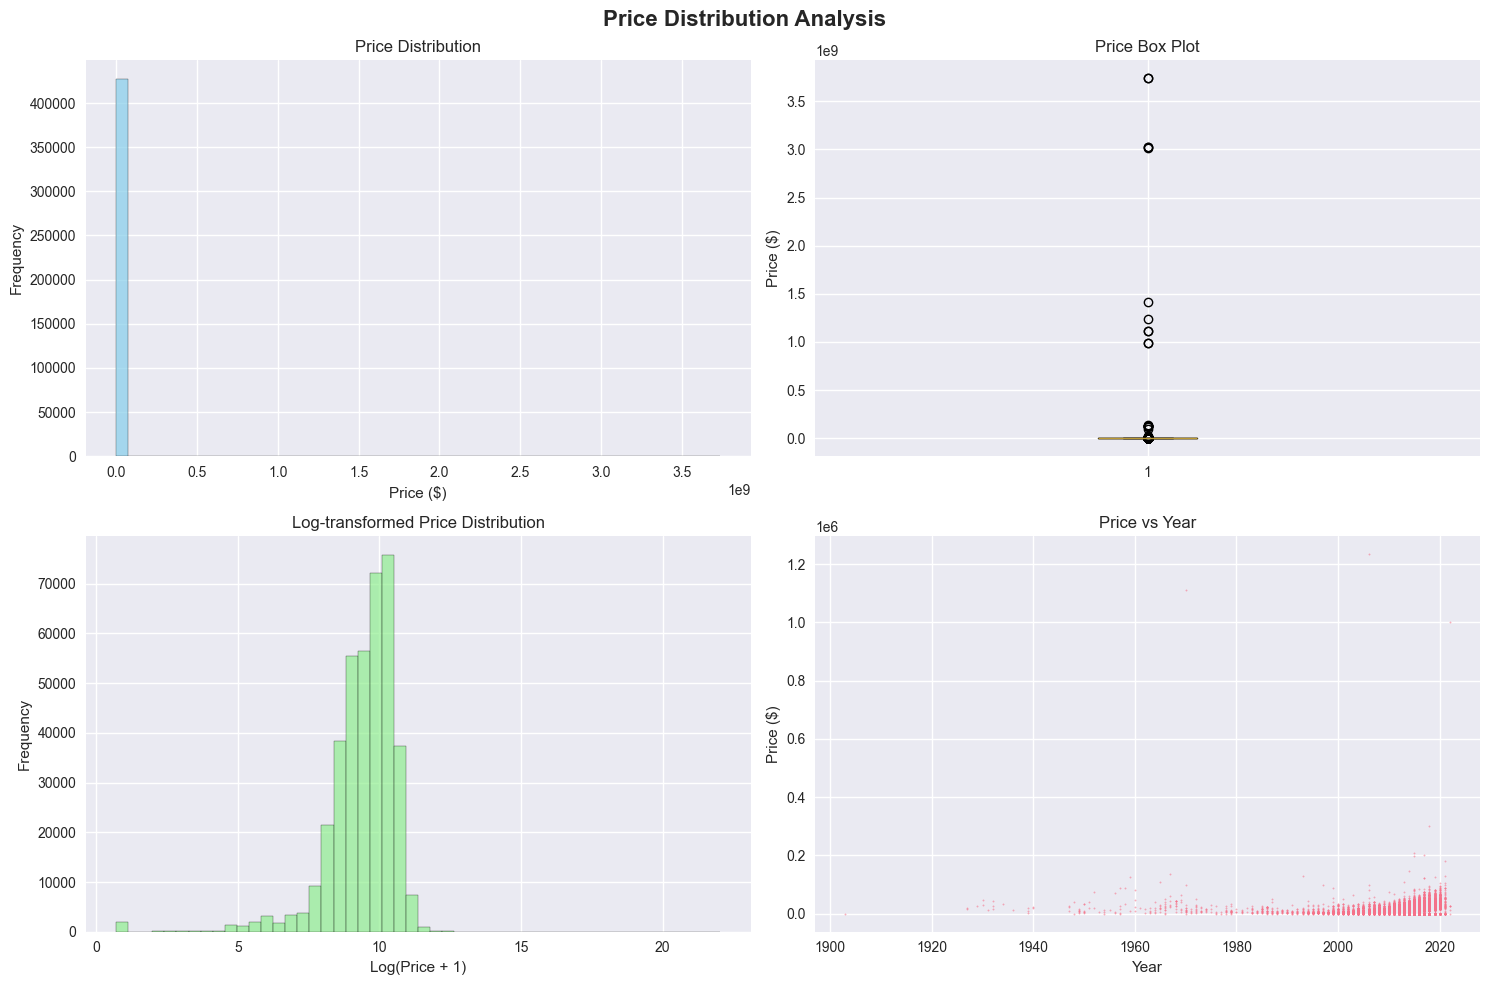

 Outlier Analysis:
   Lower bound: $-24,978.62
   Upper bound: $57,364.38
   Number of outliers: 8,177 (1.9%)


In [4]:
# =============================================================================
# CELL 4: Price Distribution Analysis (Target Variable)
# =============================================================================
def analyze_target_variable(df, target_col='price'):
    """
    Analyze the target variable (price) distribution
    """
    print("TARGET VARIABLE ANALYSIS")
    print("=" * 40)
    
    # Basic statistics
    print(f"Price Statistics:")
    price_stats = df[target_col].describe()
    display(price_stats)
    
    # Create subplots for price analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Histogram
    axes[0, 0].hist(df[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Price Distribution')
    axes[0, 0].set_xlabel('Price ($)')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Box plot
    axes[0, 1].boxplot(df[target_col])
    axes[0, 1].set_title('Price Box Plot')
    axes[0, 1].set_ylabel('Price ($)')
    
    # 3. Log-scale histogram
    log_prices = np.log1p(df[target_col][df[target_col] > 0])
    axes[1, 0].hist(log_prices, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1, 0].set_title('Log-transformed Price Distribution')
    axes[1, 0].set_xlabel('Log(Price + 1)')
    axes[1, 0].set_ylabel('Frequency')
    
    # 4. Price vs Year scatter
    if 'year' in df.columns:
        sample_size = min(10000, len(df))  # Sample for better visualization
        sample_df = df.sample(n=sample_size, random_state=42)
        axes[1, 1].scatter(sample_df['year'], sample_df[target_col], alpha=0.5, s=1)
        axes[1, 1].set_title('Price vs Year')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_ylabel('Price ($)')
    
    plt.tight_layout()
    plt.show()
    
    # Identify outliers
    Q1 = df[target_col].quantile(0.25)
    Q3 = df[target_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[target_col] < lower_bound) | (df[target_col] > upper_bound)]
    print(f" Outlier Analysis:")
    print(f"   Lower bound: ${lower_bound:,.2f}")
    print(f"   Upper bound: ${upper_bound:,.2f}")
    print(f"   Number of outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.1f}%)")


analyze_target_variable(df)


In [17]:
# =============================================================================
# CELL 5: Data Cleaning Function
# =============================================================================
def clean_dataset(df):
    """
    Comprehensive data cleaning with progress tracking
    """
    print("🧹 DATA CLEANING PROCESS")
    print("=" * 40)
    
    df_clean = df.copy()
    original_shape = df_clean.shape
    print(f" Starting shape: {original_shape}")
    
    # Step 1: Remove irrelevant columns
    columns_to_drop = ['id', 'url', 'region_url', 'image_url', 'description', 'VIN', 'county']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
    df_clean = df_clean.drop(columns=existing_cols_to_drop)
    print(f" Dropped {len(existing_cols_to_drop)} irrelevant columns: {existing_cols_to_drop}")
    
    # Step 2: Clean price column
    print(f"\n Price Cleaning:")
    print(f"   Original price range: ${df_clean['price'].min():,.0f} - ${df_clean['price'].max():,.0f}")
    
    # Remove unrealistic prices
    before_price_filter = len(df_clean)
    df_clean = df_clean[
        (df_clean['price'] > 1000) & 
        (df_clean['price'] < 200000)
    ]
    removed_price = before_price_filter - len(df_clean)
    print(f"   Removed {removed_price:,} rows with unrealistic prices")
    print(f"   New price range: ${df_clean['price'].min():,.0f} - ${df_clean['price'].max():,.0f}")
    
    # Step 3: Clean year column
    if 'year' in df_clean.columns:
        print(f"\n Year Cleaning:")
        before_year_filter = len(df_clean)
        current_year = 2024
        df_clean = df_clean[
            (df_clean['year'] >= 1990) & 
            (df_clean['year'] <= current_year)
        ]
        removed_year = before_year_filter - len(df_clean)
        print(f"   Removed {removed_year:,} rows with invalid years")
        print(f"   Year range: {df_clean['year'].min():.0f} - {df_clean['year'].max():.0f}")
    
    # Step 4: Clean odometer readings
    if 'odometer' in df_clean.columns:
        print(f"\n Odometer Cleaning:")
        before_odometer_filter = len(df_clean)
        df_clean = df_clean[df_clean['odometer'] < 400000]
        removed_odometer = before_odometer_filter - len(df_clean)
        print(f"   Removed {removed_odometer:,} rows with extreme odometer readings")
        if len(df_clean) > 0:
            print(f"   Odometer range: {df_clean['odometer'].min():,.0f} - {df_clean['odometer'].max():,.0f} miles")
    
    # Final summary
    final_shape = df_clean.shape
    total_removed = original_shape[0] - final_shape[0]
    print(f"\n CLEANING SUMMARY:")
    print(f"   Original rows: {original_shape[0]:,}")
    print(f"   Final rows: {final_shape[0]:,}")
    print(f"   Removed rows: {total_removed:,} ({total_removed/original_shape[0]*100:.1f}%)")
    print(f"   Final shape: {final_shape}")
    
    return df_clean


df_clean = clean_dataset(df)

🧹 DATA CLEANING PROCESS
 Starting shape: (426880, 26)
 Dropped 7 irrelevant columns: ['id', 'url', 'region_url', 'image_url', 'description', 'VIN', 'county']

 Price Cleaning:
   Original price range: $0 - $3,736,928,711
   Removed 47,651 rows with unrealistic prices
   New price range: $1,002 - $199,999

 Year Cleaning:
   Removed 12,803 rows with invalid years
   Year range: 1990 - 2022

 Odometer Cleaning:
   Removed 3,076 rows with extreme odometer readings
   Odometer range: 0 - 399,999 miles

 CLEANING SUMMARY:
   Original rows: 426,880
   Final rows: 363,350
   Removed rows: 63,530 (14.9%)
   Final shape: (363350, 19)


TARGET VARIABLE ANALYSIS
Price Statistics:


count    363350.000000
mean      19613.990687
std       14778.705341
min        1002.000000
25%        7995.000000
50%       15995.000000
75%       27995.000000
max      199999.000000
Name: price, dtype: float64

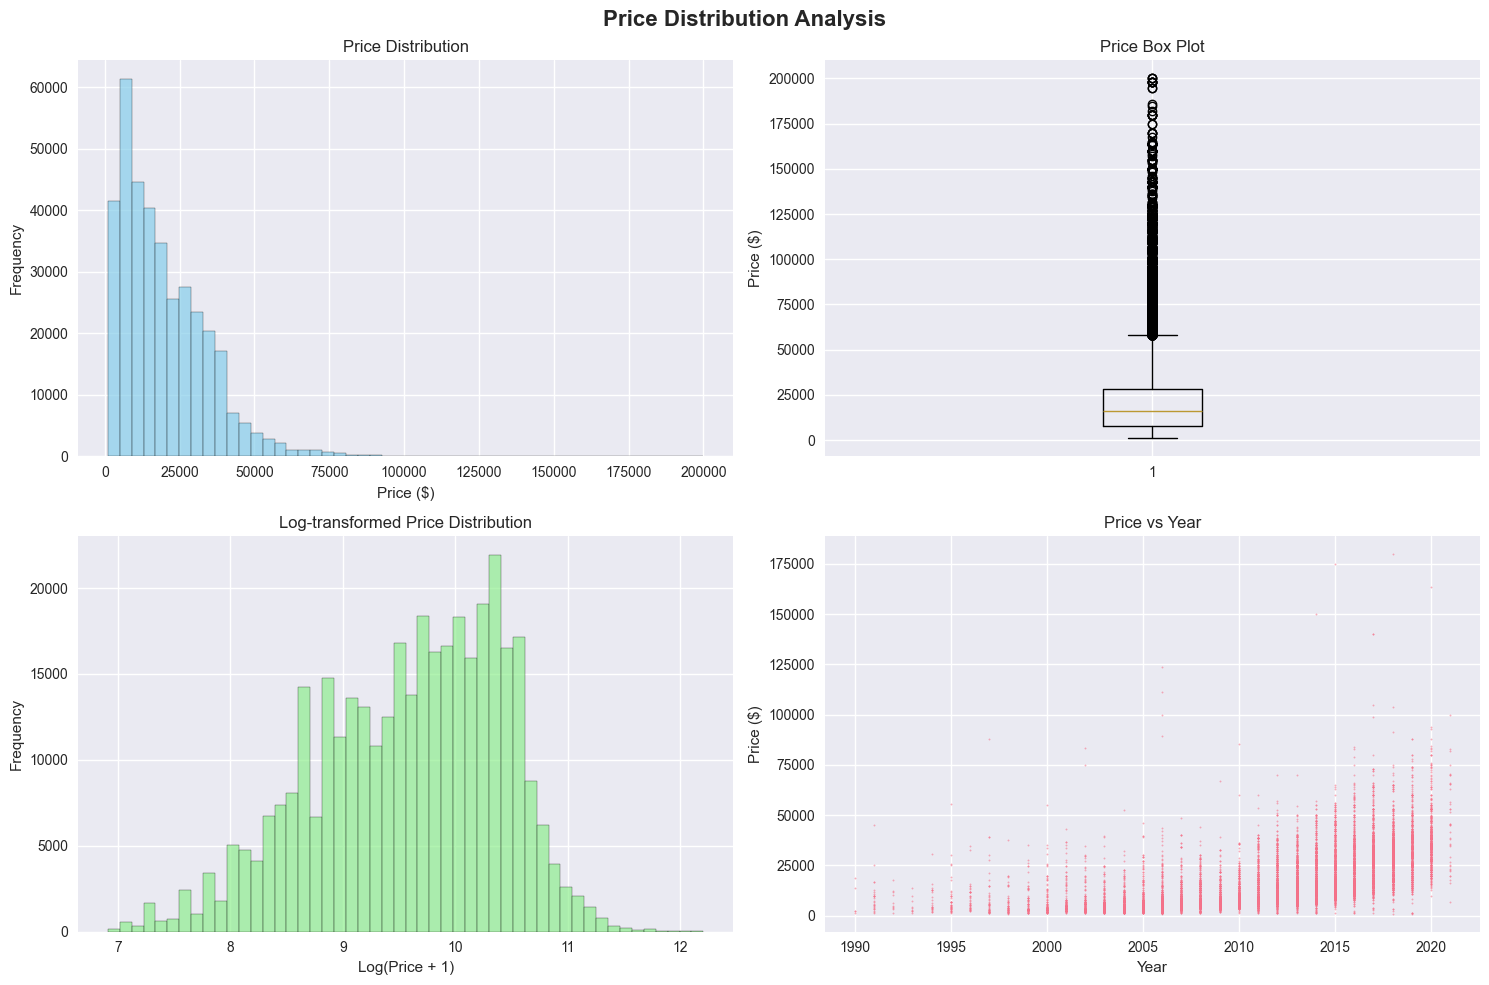

 Outlier Analysis:
   Lower bound: $-22,005.00
   Upper bound: $57,995.00
   Number of outliers: 7,070 (1.9%)


In [8]:
analyze_target_variable(df_clean)

In [6]:
# =============================================================================
# CELL 6: Handle Missing Values
# =============================================================================
def handle_missing_values(df):
    """
    Strategic missing value imputation with visualization
    """
    print(" MISSING VALUES HANDLING")
    print("=" * 40)
    
    df_filled = df.copy()
    
    # Show missing values before imputation
    print("Missing values before imputation:")
    missing_before = df_filled.isnull().sum()
    missing_before_filtered = missing_before[missing_before > 0]
    if len(missing_before_filtered) > 0:
        display(missing_before_filtered.to_frame('Missing Count'))
    else:
        print(" No missing values found!")
        return df_filled
    
    # Numerical columns - median imputation
    numerical_cols = df_filled.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col != 'price']  # Don't impute target
    print(f"Numerical columns to impute: {numerical_cols}")
    
    print(f"\n Numerical Columns Imputation:")
    for col in numerical_cols:
        if df_filled[col].isnull().sum() > 0:
            median_val = df_filled[col].median()
            missing_count = df_filled[col].isnull().sum()
            df_filled[col].fillna(median_val, inplace=True)
            print(f"    {col}: filled {missing_count:,} values with median {median_val:.2f}") 
    
    
    
    # Categorical columns - strategic imputation
    categorical_strategies = {
        'manufacturer': ('mode', 'Most common manufacturer'),
        'model': ('unknown', 'Unknown model'),
        'condition': ('good', 'Good condition (reasonable assumption)'),
        'cylinders': ('mode', 'Most common cylinder count'),
        'fuel': ('mode', 'most common fuel type'),
        'title_status': ('mode', 'most common title status'),
        'transmission': ('mode', 'Most common transmission type'),
        'drive': ('mode', 'most common drive type'),
        'size': ('mode', 'most common size category'),
        'type': ('mode', 'most common vehicle type'),
        'paint_color': ('unknown', 'Unknown paint color')
    }
    
    
    print(f"\n  Categorical Columns Imputation:")
    for col, (strategy, description) in categorical_strategies.items():
        if col in df_filled.columns and df_filled[col].isnull().sum() > 0:
            missing_count = df_filled[col].isnull().sum()
            
            if strategy == 'mode':
                mode_val = df_filled[col].mode()
                fill_value = mode_val[0] if len(mode_val) > 0 else 'unknown'
            else:
                fill_value = strategy
            
            df_filled[col].fillna(fill_value, inplace=True)
            print(f"    {col}: filled {missing_count:,} values with '{fill_value}'")
            print(f"      Reason: {description}")
    
    # Summary
    print(f"\n IMPUTATION SUMMARY:")
    missing_after = df_filled.isnull().sum().sum()
    print(f"   Missing values after imputation: {missing_after}")
    
    if missing_after == 0:
        print("    All missing values successfully handled!")
    else:
        remaining_missing = df_filled.isnull().sum()
        remaining_missing = remaining_missing[remaining_missing > 0]
        print("     Remaining missing values:")
        display(remaining_missing.to_frame('Missing Count'))
    
    return df_filled


df_filled = handle_missing_values(df_clean)

 MISSING VALUES HANDLING
Missing values before imputation:


,Missing Count
manufacturer,11557
model,3404
condition,139415
cylinders,150936
fuel,2109
title_status,6468
transmission,1504
drive,110758
size,265343
type,76380


Numerical columns to impute: ['year', 'odometer', 'lat', 'long']

 Numerical Columns Imputation:
    lat: filled 3,366 values with median 39.26
    long: filled 3,366 values with median -87.93

  Categorical Columns Imputation:
    manufacturer: filled 11,557 values with 'ford'
      Reason: Most common manufacturer
    model: filled 3,404 values with 'unknown'
      Reason: Unknown model
    condition: filled 139,415 values with 'good'
      Reason: Good condition (reasonable assumption)
    cylinders: filled 150,936 values with '6 cylinders'
      Reason: Most common cylinder count
    fuel: filled 2,109 values with 'gas'
      Reason: most common fuel type
    title_status: filled 6,468 values with 'clean'
      Reason: most common title status
    transmission: filled 1,504 values with 'automatic'
      Reason: Most common transmission type
    drive: filled 110,758 values with '4wd'
      Reason: most common drive type
    size: filled 265,343 values with 'full-size'
      Reason:

In [7]:
# CELL 6.2: Handle 'cylinders' column specifically
# Extract numbers (e.g., "4 cylinders" → 4, "other" → NaN)
df_filled['cylinders'] = (
        df_filled['cylinders']
        .str.extract('(\d+)')       # Capture digits
        .astype(float)              # Convert to float (NaN for 'other')
    )

mode_cylinders = df_filled['cylinders'].mode()[0]
df_filled['cylinders'] = (
        df_filled['cylinders']
        .fillna(mode_cylinders)  # Replace 'other' with mode
        .astype(int)             # Convert to integer
    )
    
print("Unique cylinder values after cleaning:")
print(df_filled['cylinders'].unique())

Unique cylinder values after cleaning:
[ 8  6  4  5  3 10 12]


In [8]:
# =============================================================================
# CELL 7: Feature Engineering
# =============================================================================
def create_new_features(df):
    """
    Create meaningful features for car price prediction
    """
    print("🔧 FEATURE ENGINEERING")
    print("=" * 40)
    
    df_featured = df.copy()
    original_features = df_featured.shape[1]
    
    # 1. Car age feature
    if 'year' in df_featured.columns:
        current_year = 2025
        df_featured['car_age'] = current_year - df_featured['year']
        print(f" Created 'car_age' feature (current_year - year)")
        print(f"   Age range: {df_featured['car_age'].min():.0f} - {df_featured['car_age'].max():.0f} years")
        df_featured = df_featured.drop(columns=['year'])  # Drop year after creating car_age
        print("   Dropped 'year' column after creating 'car_age'")
    
    
    # 2. Mileage per year
    #if 'odometer' in df_featured.columns and 'car_age' in df_featured.columns:
        #df_featured['mileage_per_year'] = df_featured['odometer'] / (df_featured['car_age'] + 1)
        #print(f" Created 'mileage_per_year' feature")
        #print(f"   Range: {df_featured['mileage_per_year'].min():,.0f} - {df_featured['mileage_per_year'].max():,.0f} miles/year")
        
        # Interaction term: Age * Odometer (older high-mileage cars depreciate faster)
        df_featured['age_mileage_interaction'] = df_featured['car_age'] * df_featured['odometer']
        print(f" Created 'age_mileage_interaction' feature")
        print(f"   Range: {df_featured['age_mileage_interaction'].min():,.0f} - {df_featured['age_mileage_interaction'].max():,.0f}")

    # 5. Manufacturer popularity3. Manufacturer popularity
    # Count how many cars each manufacturer has in the dataset
    # And create a new feature based on this count
    if 'manufacturer' in df_featured.columns:
        manufacturer_counts = df_featured['manufacturer'].value_counts()
        df_featured['manufacturer_popularity'] = df_featured['manufacturer'].map(manufacturer_counts)
        print(f" Created 'manufacturer_popularity' feature")
        print(f"   Most popular: {manufacturer_counts.index[0]} ({manufacturer_counts.iloc[0]:,} cars)")
    
    
    
    # 6. Extract posting date features
    if 'posting_date' in df_featured.columns:
        try:
            df_featured['posting_date'] = pd.to_datetime(df_featured['posting_date'])
            df_featured['posting_month'] = df_featured['posting_date'].dt.month
            df_featured['posting_year'] = df_featured['posting_date'].dt.year
            df_featured['posting_day_of_week'] = df_featured['posting_date'].dt.dayofweek
            print(f" Extracted posting date features (month, year, day_of_week)")
        except:
            print("  Could not parse posting_date column")
            
    
    # 7. Condition encoding
    if 'condition' in df_featured.columns:
        condition_mapping = {
            'new': 5,
            'like new': 4,
            'excellent': 3,
            'good': 2,
            'fair': 1,
            'salvage': 0
        }
        df_featured['condition_encoded'] = df_featured['condition'].map(condition_mapping)
        print(f" Encoded 'condition' feature into 'condition_encoded'")
        print(f"   Unique values: {df_featured['condition_encoded'].unique()}")
        df_featured = df_featured.drop(columns=['condition'])  # Drop original condition column
        print("   Dropped original 'condition' column after encoding")
        
    
    # 8. Extract top N frequent models (group rare as "other")
    if 'model' in df_featured.columns:
        print(f" Grouping rare models into 'other'")
        # Count top 100 models
        top_models = df_featured['model'].value_counts().nlargest(100).index
        df_featured['top_model_grouped'] = df_featured['model'].apply(lambda x: x if x in top_models else 'other')
        print(f"   Grouped {len(df_featured['model'].unique()) - len(top_models)} rare models into 'other'")
        print(f"   Unique top models: {df_featured['top_model_grouped'].nunique()}")
    
    # 9. Odometer bins
    #if 'odometer' in df_featured.columns:
        #print(f" Creating odometer bins")
        #bins = [0, 50000, 100000, 150000, 200000, 250000, 300000, np.inf]
        #labels = ['<50k', '50k-100k', '100k-150k', '150k-200k', '200k-250k', '250k-300k', '>300k']
        #df_featured['odometer_bin'] = pd.cut(df_featured['odometer'], bins=bins, labels=labels)
        #print(f"   Created odometer bins: {labels}")
    
    # 10. Odometer Log Transformation
    if 'odometer' in df_featured.columns:
        print(f" Applying log transformation to odometer")
        df_featured['odometer_log'] = np.log1p(df_featured['odometer'])
        print(f"   Odometer log range: {df_featured['odometer_log'].min():.2f} - {df_featured['odometer_log'].max():.2f}") 
    else:
        print("  'odometer' column not found, skipping log transformation")
    
    # 11. Price Log Transformation
    if 'price' in df_featured.columns:
        print(f" Applying log transformation to price")
        df_featured['price_log'] = np.log1p(df_featured['price'])  # log1p handles zero prices
        print(f"   Price log range: {df_featured['price_log'].min():.2f} - {df_featured['price_log'].max():.2f}")
    else:
        print("  'price' column not found, skipping log transformation")
    
    
    
      
    new_features = df_featured.shape[1]
    print(f"\n FEATURE ENGINEERING SUMMARY:")
    print(f"   Original features: {original_features}")
    print(f"   New features: {new_features}")
    print(f"   Added features: {new_features - original_features}")
    
    return df_featured


df_featured = create_new_features(df_filled)

🔧 FEATURE ENGINEERING
 Created 'car_age' feature (current_year - year)
   Age range: 3 - 35 years
   Dropped 'year' column after creating 'car_age'
 Created 'age_mileage_interaction' feature
   Range: 0 - 13,510,000
 Created 'manufacturer_popularity' feature
   Most popular: ford (72,468 cars)
  Could not parse posting_date column
 Encoded 'condition' feature into 'condition_encoded'
   Unique values: [2 3 1 4 5 0]
   Dropped original 'condition' column after encoding
 Grouping rare models into 'other'
   Grouped 24270 rare models into 'other'
   Unique top models: 101
 Applying log transformation to odometer
   Odometer log range: 0.00 - 12.90
 Applying log transformation to price
   Price log range: 6.22 - 12.21

 FEATURE ENGINEERING SUMMARY:
   Original features: 19
   New features: 24
   Added features: 5


In [9]:
#number of unique values in each column
def unique_values_summary(df):
    """
    Display unique values count for each column
    """
    print("UNIQUE VALUES SUMMARY")
    print("=" * 40)
    
    df_ucnts = df.copy()
    
    unique_counts = df_ucnts.nunique()
    unique_df = pd.DataFrame({
        'Column': unique_counts.index,
        'Unique_Count': unique_counts.values,
        'Data_type': df_ucnts.dtypes.values
    }).sort_values('Unique_Count', ascending=False)
    
        
    return unique_df

unique_values_summary(df_featured)

UNIQUE VALUES SUMMARY


,Column,Unique_Count,Data_type
16,posting_date,290817,object
18,age_mileage_interaction,127605,float64
6,odometer,95051,float64
22,odometer_log,95051,float64
15,long,48290,float64
14,lat,47777,float64
3,model,24370,object
1,price,14904,int64
23,price_log,14904,float64
0,region,404,object


In [10]:
# =============================================================================
# CELL 8.1: One-Hot Categorical Encoding
# Selected Categorical and Numerical Features to Use for the Model
# =============================================================================
def encode_categorical_features(df):
    """
    One-hot encode categorical features with progress tracking
    """
    print(" CATEGORICAL ENCODING")
    print("=" * 40)
    
    df_encoded = df.copy()
    
    categorical_cols_to_encode = ['fuel', 'title_status', 'transmission', 'drive', 'type', 'size']
    numerical_cols_to_keep = ['price_log', 'odometer_log', 'car_age', 'manufacturer_popularity', 'condition_encoded']
    
    print(f"Categorical columns to encode: {categorical_cols_to_encode}")
    print(f"Numerical columns to keep: {numerical_cols_to_keep}")
    
    categorical_subset = df_encoded[categorical_cols_to_encode].copy()
    numerical_subset = df_encoded[numerical_cols_to_keep].copy()
    
    # One-hot encode using pd.get_dummies
    categorical_encoded = pd.get_dummies(categorical_subset, columns=categorical_cols_to_encode, drop_first=True)
    
    print(f"After encoding categorical features: {categorical_encoded.shape}")
    print(f"Encoded columns: {list(categorical_encoded.columns)}")
    
    
    final_features = pd.concat([numerical_subset, categorical_encoded], axis=1)
    
    df_encoded = final_features
    
    return df_encoded


df_encoded = encode_categorical_features(df_featured)

 CATEGORICAL ENCODING
Categorical columns to encode: ['fuel', 'title_status', 'transmission', 'drive', 'type', 'size']
Numerical columns to keep: ['price_log', 'odometer_log', 'car_age', 'manufacturer_popularity', 'condition_encoded']
After encoding categorical features: (367519, 28)
Encoded columns: ['fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other', 'title_status_lien', 'title_status_missing', 'title_status_parts only', 'title_status_rebuilt', 'title_status_salvage', 'transmission_manual', 'transmission_other', 'drive_fwd', 'drive_rwd', 'type_bus', 'type_convertible', 'type_coupe', 'type_hatchback', 'type_mini-van', 'type_offroad', 'type_other', 'type_pickup', 'type_sedan', 'type_truck', 'type_van', 'type_wagon', 'size_full-size', 'size_mid-size', 'size_sub-compact']


In [11]:
# =============================================================================
# CELL 9: Prepare Data for Machine Learning
# =============================================================================
def prepare_ml_data(df, target_col='price_log'):
    """
    Prepare features and target for machine learning
    """
    print(" PREPARING DATA FOR MACHINE LEARNING")
    print("=" * 50)
    
    # Separate features and target
    feature_cols = [col for col in df.columns if col != target_col]
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()  
    
    print(f" Data Preparation Summary:")
    print(f"   Total samples: {len(df):,}")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Target: {target_col}")
    
    print(f"\n Feature List:")
    for i, col in enumerate(feature_cols, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n Target Variable Summary:")
    print(f"   Min price: ${y.min():,.2f}")
    print(f"   Max price: ${y.max():,.2f}")
    print(f"   Mean price: ${y.mean():,.2f}")
    print(f"   Median price: ${y.median():,.2f}")
    
    # Check for any remaining issues
    print(f"\n Data Quality Check:")
    print(f"   Missing values in X: {X.isnull().sum().sum()}")
    print(f"   Missing values in y: {y.isnull().sum()}")
    print(f"   Infinite values in X: {np.isinf(X.select_dtypes(include=[np.number])).sum().sum()}")
    print(f"   Infinite values in y: {np.isinf(y).sum()}")
    
    return X, y, feature_cols


X, y, feature_names = prepare_ml_data(df_encoded)

 PREPARING DATA FOR MACHINE LEARNING
 Data Preparation Summary:
   Total samples: 367,519
   Features: 32
   Target: price_log

 Feature List:
    1. odometer_log
    2. car_age
    3. manufacturer_popularity
    4. condition_encoded
    5. fuel_electric
    6. fuel_gas
    7. fuel_hybrid
    8. fuel_other
    9. title_status_lien
   10. title_status_missing
   11. title_status_parts only
   12. title_status_rebuilt
   13. title_status_salvage
   14. transmission_manual
   15. transmission_other
   16. drive_fwd
   17. drive_rwd
   18. type_bus
   19. type_convertible
   20. type_coupe
   21. type_hatchback
   22. type_mini-van
   23. type_offroad
   24. type_other
   25. type_pickup
   26. type_sedan
   27. type_truck
   28. type_van
   29. type_wagon
   30. size_full-size
   31. size_mid-size
   32. size_sub-compact

 Target Variable Summary:
   Min price: $6.22
   Max price: $12.21
   Mean price: $9.55
   Median price: $9.68

 Data Quality Check:
   Missing values in X: 0
   Missing

In [12]:
# =============================================================================
# CELL 10: Train-Test Split and Scaling
# =============================================================================
def split_and_scale_data(X, y, test_size=0.2, random_state=42):
    """
    Split data and apply feature scaling
    """
    print("  DATA SPLITTING AND SCALING")
    print("=" * 40)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=None
    )
    
    print(f" Data Split Summary:")
    print(f"   Training set: {X_train.shape[0]:,} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Testing set: {X_test.shape[0]:,} samples ({test_size*100:.0f}%)")
    print(f"   Features: {X_train.shape[1]}")
    
    # Feature scaling
    print(f"\n  Feature Scaling:")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"    Applied StandardScaler")
    print(f"   Training set scaled shape: {X_train_scaled.shape}")
    print(f"   Testing set scaled shape: {X_test_scaled.shape}")
    
    # Show scaling statistics
    print(f"\n Scaling Statistics (sample of features):")
    feature_stats = pd.DataFrame({
        'Feature': X.columns[:5],  # Show first 5 features
        'Original_Mean': X.iloc[:, :5].mean().round(2),
        'Original_Std': X.iloc[:, :5].std().round(2),
        'Scaled_Mean': X_train_scaled[:, :5].mean(axis=0).round(2),
        'Scaled_Std': X_train_scaled[:, :5].std(axis=0).round(2)
    })
    display(feature_stats)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


X_train_scaled, X_test_scaled, y_train, y_test, scaler = split_and_scale_data(X, y)

  DATA SPLITTING AND SCALING
 Data Split Summary:
   Training set: 294,015 samples (80%)
   Testing set: 73,504 samples (20%)
   Features: 32

  Feature Scaling:
    Applied StandardScaler
   Training set scaled shape: (294015, 32)
   Testing set scaled shape: (73504, 32)

 Scaling Statistics (sample of features):


,Feature,Original_Mean,Original_Std,Scaled_Mean,Scaled_Std
odometer_log,odometer_log,11.00,1.45,0.0,1.0
car_age,car_age,12.72,5.83,0.0,1.0
manufacturer_popularity,manufacturer_popularity,28982.10,24942.99,-0.0,1.0
condition_encoded,condition_encoded,2.33,0.61,-0.0,1.0
fuel_electric,fuel_electric,0.00,0.07,-0.0,1.0


In [13]:
# =============================================================================
# CELL 11: Train XGBoost Model
# =============================================================================
def train_xgboost_model(X_train, y_train, X_val=None, y_val=None):
    """
    Train XGBoost model with detailed output and optional validation
    """
    print(" TRAINING XGBOOST MODEL")
    print("=" * 50)
    
    # XGBoost parameters
    xgb_params = {
        'n_estimators': 1000,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50 if X_val is not None and y_val is not None else None,
        'eval_metric': 'rmse'
    }
    
    print(" Model Configuration:")
    for param, value in xgb_params.items():
        if value is not None:
            print(f"   {param}: {value}")
    
    # Create the model with all parameters
    print(f"\n Training in progress...")
    model = xgb.XGBRegressor(**{k: v for k, v in xgb_params.items() if v is not None})
    
    # Set up evaluation set for early stopping if validation data provided
    eval_set = None
    if X_val is not None and y_val is not None:
        eval_set = [(X_val, y_val)]
        print(f"   Using validation set for early stopping")
    
    # Fit the model
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=False
    )
    
    print(" Model training completed!")
    
    # Model information
    print(f"\n Model Information:")
    print(f"   Model type: XGBoost Regressor")
    print(f"   Features used: {X_train.shape[1]}")
    print(f"   Training samples: {X_train.shape[0]:,}")
    print(f"   Trees built: {model.n_estimators}")
    if hasattr(model, 'best_iteration') and model.best_iteration:
        print(f"   Best iteration: {model.best_iteration}")
        print(f"   Early stopping triggered: Yes")
    else:
        print(f"   Early stopping triggered: No")
    
    # Feature importance statistics
    feature_importance = model.feature_importances_
    importance_stats = pd.Series(feature_importance)
    
    print(f"\n Feature Importance Statistics:")
    print(f"   Mean importance: {importance_stats.mean():.4f}")
    print(f"   Std importance: {importance_stats.std():.4f}")
    print(f"   Min importance: {importance_stats.min():.4f}")
    print(f"   Max importance: {importance_stats.max():.4f}")
    print(f"   Features with >1% importance: {(importance_stats > 0.01).sum()}")
    
    # Top 5 most important features (if feature names available)
    if hasattr(X_train, 'columns'):
        top_features = pd.Series(feature_importance, index=X_train.columns).nlargest(5)
        print(f"\n Top 5 Most Important Features:")
        for i, (feature, importance) in enumerate(top_features.items(), 1):
            print(f"   {i}. {feature}: {importance:.4f}")
    
    return model


# Train the model
model = train_xgboost_model(X_train_scaled, y_train)




 TRAINING XGBOOST MODEL
 Model Configuration:
   n_estimators: 1000
   max_depth: 6
   learning_rate: 0.1
   subsample: 0.8
   colsample_bytree: 0.8
   random_state: 42
   n_jobs: -1
   eval_metric: rmse

 Training in progress...
 Model training completed!

 Model Information:
   Model type: XGBoost Regressor
   Features used: 32
   Training samples: 294,015
   Trees built: 1000
   Early stopping triggered: No

 Feature Importance Statistics:
   Mean importance: 0.0312
   Std importance: 0.0364
   Min importance: 0.0030
   Max importance: 0.1557
   Features with >1% importance: 22


In [15]:
# Step 12.2: Model Evaluation 
# Log scale predictions and metrics
# And Dollar scale predictions and metrics
# Convert predictions back to dollar scale
print("\n" + "=" * 60)
print("STEP 12: MODEL EVALUATION")
print("=" * 60)

def evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    """Comprehensive model evaluation for XGBoost"""
    
    # Make predictions (log scale)
    y_train_pred_log = model.predict(X_train)
    y_test_pred_log = model.predict(X_test)
    
    # Make predictions (actual dollar scale)
    y_train_pred_actual = np.expm1(y_train_pred_log)
    y_test_pred_actual = np.expm1(y_test_pred_log)
    y_train_actual = np.expm1(y_train)
    y_test_actual = np.expm1(y_test)
    
    # Calculate metrics (log scale)
    train_mse_log = mean_squared_error(y_train, y_train_pred_log)
    test_mse_log = mean_squared_error(y_test, y_test_pred_log)
    train_rmse_log = np.sqrt(train_mse_log)
    test_rmse_log = np.sqrt(test_mse_log)
    train_mae_log = mean_absolute_error(y_train, y_train_pred_log)
    test_mae_log = mean_absolute_error(y_test, y_test_pred_log)
    train_r2_log = r2_score(y_train, y_train_pred_log)
    test_r2_log = r2_score(y_test, y_test_pred_log)
    
    # Calculate metrics (actual scale)
    train_mse_actual = mean_squared_error(y_train_actual, y_train_pred_actual)
    test_mse_actual = mean_squared_error(y_test_actual, y_test_pred_actual)
    train_rmse_actual = np.sqrt(train_mse_actual)
    test_rmse_actual = np.sqrt(test_mse_actual)
    train_mae_actual = mean_absolute_error(y_train_actual, y_train_pred_actual)
    test_mae_actual = mean_absolute_error(y_test_actual, y_test_pred_actual)
    train_r2_actual = r2_score(y_train_actual, y_train_pred_actual)
    test_r2_actual = r2_score(y_test_actual, y_test_pred_actual)
    
    # Calculate additional metrics
    train_mape = np.mean(np.abs((y_train_actual - y_train_pred_actual) / y_train_actual)) * 100
    test_mape = np.mean(np.abs((y_test_actual - y_test_pred_actual) / y_test_actual)) * 100
    
    # Calculate relative errors (percentage errors for each prediction)
    train_relative_errors = ((y_train_pred_actual - y_train_actual) / y_train_actual) * 100
    test_relative_errors = ((y_test_pred_actual - y_test_actual) / y_test_actual) * 100
    
    # Relative error statistics
    train_relative_error_stats = {
        'mean': np.mean(train_relative_errors),
        'median': np.median(train_relative_errors),
        'std': np.std(train_relative_errors),
        'q25': np.percentile(train_relative_errors, 25),
        'q75': np.percentile(train_relative_errors, 75),
        'within_10pct': np.mean(np.abs(train_relative_errors) <= 10) * 100,
        'within_20pct': np.mean(np.abs(train_relative_errors) <= 20) * 100,
        'within_30pct': np.mean(np.abs(train_relative_errors) <= 30) * 100
    }
    
    test_relative_error_stats = {
        'mean': np.mean(test_relative_errors),
        'median': np.median(test_relative_errors),
        'std': np.std(test_relative_errors),
        'q25': np.percentile(test_relative_errors, 25),
        'q75': np.percentile(test_relative_errors, 75),
        'within_10pct': np.mean(np.abs(test_relative_errors) <= 10) * 100,
        'within_20pct': np.mean(np.abs(test_relative_errors) <= 20) * 100,
        'within_30pct': np.mean(np.abs(test_relative_errors) <= 30) * 100
    }
    
    # Print evaluation results
    print(" MODEL PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f" Log Scale Metrics:")
    print(f"   Training R²: {train_r2_log:.4f}")
    print(f"   Testing R²:  {test_r2_log:.4f}")
    print(f"   Training RMSE: {train_rmse_log:.4f}")
    print(f"   Testing RMSE:  {test_rmse_log:.4f}")
    print(f"   Training MAE:  {train_mae_log:.4f}")
    print(f"   Testing MAE:   {test_mae_log:.4f}")
    
    print(f"\n Actual Dollar Scale Metrics:")
    print(f"   Training R²: {train_r2_actual:.4f}")
    print(f"   Testing R²:  {test_r2_actual:.4f}")
    print(f"   Training RMSE: ${train_rmse_actual:,.0f}")
    print(f"   Testing RMSE:  ${test_rmse_actual:,.0f}")
    print(f"   Training MAE:  ${train_mae_actual:,.0f}")
    print(f"   Testing MAE:   ${test_mae_actual:,.0f}")
    print(f"   Training MAPE: {train_mape:.2f}%")
    print(f"   Testing MAPE:  {test_mape:.2f}%")
    
    # Relative Error Analysis
    print(f"\n RELATIVE ERROR ANALYSIS")
    print("=" * 50)
    print(f" Training Set Relative Errors:")
    print(f"   Mean relative error: {train_relative_error_stats['mean']:+.2f}%")
    print(f"   Median relative error: {train_relative_error_stats['median']:+.2f}%")
    print(f"   Std deviation: {train_relative_error_stats['std']:.2f}%")
    print(f"   25th percentile: {train_relative_error_stats['q25']:+.2f}%")
    print(f"   75th percentile: {train_relative_error_stats['q75']:+.2f}%")
    print(f"   Within ±10%: {train_relative_error_stats['within_10pct']:.1f}% of predictions")
    print(f"   Within ±20%: {train_relative_error_stats['within_20pct']:.1f}% of predictions")
    print(f"   Within ±30%: {train_relative_error_stats['within_30pct']:.1f}% of predictions")
    
    print(f"\n Testing Set Relative Errors:")
    print(f"   Mean relative error: {test_relative_error_stats['mean']:+.2f}%")
    print(f"   Median relative error: {test_relative_error_stats['median']:+.2f}%")
    print(f"   Std deviation: {test_relative_error_stats['std']:.2f}%")
    print(f"   25th percentile: {test_relative_error_stats['q25']:+.2f}%")
    print(f"   75th percentile: {test_relative_error_stats['q75']:+.2f}%")
    print(f"   Within ±10%: {test_relative_error_stats['within_10pct']:.1f}% of predictions")
    print(f"   Within ±20%: {test_relative_error_stats['within_20pct']:.1f}% of predictions")
    print(f"   Within ±30%: {test_relative_error_stats['within_30pct']:.1f}% of predictions")
    
    # Relative error interpretation
    print(f"\n Relative Error Interpretation:")
    if test_relative_error_stats['within_10pct'] >= 70:
        print(f"    Excellent: {test_relative_error_stats['within_10pct']:.1f}% predictions within ±10%")
    elif test_relative_error_stats['within_20pct'] >= 80:
        print(f"    Good: {test_relative_error_stats['within_20pct']:.1f}% predictions within ±20%")
    elif test_relative_error_stats['within_30pct'] >= 85:
        print(f"     Fair: {test_relative_error_stats['within_30pct']:.1f}% predictions within ±30%")
    else:
        print(f"    Poor: Only {test_relative_error_stats['within_30pct']:.1f}% predictions within ±30%")
    
    # Bias analysis
    if abs(test_relative_error_stats['mean']) > 5:
        if test_relative_error_stats['mean'] > 0:
            print(f"     Model shows positive bias: tends to overpredict by {test_relative_error_stats['mean']:.1f}%")
        else:
            print(f"     Model shows negative bias: tends to underpredict by {abs(test_relative_error_stats['mean']):.1f}%")
    else:
        print(f"    Model shows minimal bias: mean error = {test_relative_error_stats['mean']:+.2f}%")
    
    # Model generalization check
    r2_diff = train_r2_log - test_r2_log
    rmse_ratio = test_rmse_log / train_rmse_log
    
    print(f"\n Model Generalization Analysis:")
    print(f"   R² difference (train - test): {r2_diff:.4f}")
    print(f"   RMSE ratio (test / train): {rmse_ratio:.4f}")
    
    if r2_diff > 0.1:
        print("     Warning: Potential overfitting detected!")
        print("    Consider: reducing max_depth, increasing regularization")
    elif r2_diff < -0.05:
        print("     Warning: Potential underfitting detected!")
        print("    Consider: increasing max_depth, more estimators")
    else:
        print("    Model appears to generalize well")
    
    # Feature importance analysis (XGBoost specific)
    print(f"\n FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    
    # Get feature importance from XGBoost
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_,
            'importance_pct': model.feature_importances_ * 100
        }).sort_values('importance', ascending=False)
        
        print(" Top 10 Most Important Features:")
        top_features = feature_importance.head(10)
        for i, (_, row) in enumerate(top_features.iterrows(), 1):
            print(f"   {i:2d}. {row['feature']:<25} {row['importance']:.4f} ({row['importance_pct']:.1f}%)")
        
        # Feature importance statistics
        print(f"\n Feature Importance Statistics:")
        print(f"   Total features: {len(feature_importance)}")
        print(f"   Features with >1% importance: {(feature_importance['importance_pct'] > 1).sum()}")
        print(f"   Features with >5% importance: {(feature_importance['importance_pct'] > 5).sum()}")
        print(f"   Top 10 features contribute: {feature_importance.head(10)['importance_pct'].sum():.1f}%")
        
    else:
        print("   Feature importance not available for this model type")
        feature_importance = None
    
    # Prediction quality analysis
    print(f"\n PREDICTION QUALITY ANALYSIS")
    print("=" * 50)
    
    # Calculate prediction ranges
    train_pred_range = y_train_pred_actual.max() - y_train_pred_actual.min()
    test_pred_range = y_test_pred_actual.max() - y_test_pred_actual.min()
    train_actual_range = y_train_actual.max() - y_train_actual.min()
    test_actual_range = y_test_actual.max() - y_test_actual.min()
    
    print(f"   Training Set:")
    print(f"     Actual range: ${train_actual_range:,.0f}")
    print(f"     Predicted range: ${train_pred_range:,.0f}")
    print(f"     Mean absolute error: ${train_mae_actual:,.0f}")
    
    print(f"   Testing Set:")
    print(f"     Actual range: ${test_actual_range:,.0f}")
    print(f"     Predicted range: ${test_pred_range:,.0f}")
    print(f"     Mean absolute error: ${test_mae_actual:,.0f}")
    
    return {
        'metrics': {
            'train_r2_log': train_r2_log, 'test_r2_log': test_r2_log,
            'train_rmse_log': train_rmse_log, 'test_rmse_log': test_rmse_log,
            'train_mae_log': train_mae_log, 'test_mae_log': test_mae_log,
            'train_r2_actual': train_r2_actual, 'test_r2_actual': test_r2_actual,
            'train_rmse_actual': train_rmse_actual, 'test_rmse_actual': test_rmse_actual,
            'train_mae_actual': train_mae_actual, 'test_mae_actual': test_mae_actual,
            'train_mape': train_mape, 'test_mape': test_mape
        },
        'relative_errors': {
            'train_errors': train_relative_errors,
            'test_errors': test_relative_errors,
            'train_stats': train_relative_error_stats,
            'test_stats': test_relative_error_stats
        },
        'predictions': {
            'train_log': y_train_pred_log, 'test_log': y_test_pred_log,
            'train_actual': y_train_pred_actual, 'test_actual': y_test_pred_actual
        },
        'actuals': {
            'train_log': y_train, 'test_log': y_test,
            'train_actual': y_train_actual, 'test_actual': y_test_actual
        },
        'feature_importance': feature_importance,
        'generalization': {
            'r2_difference': r2_diff,
            'rmse_ratio': rmse_ratio,
            'overfitting_risk': r2_diff > 0.1
        }
    }

# Run the evaluation
evaluation_results = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, feature_names)


STEP 12: MODEL EVALUATION
 MODEL PERFORMANCE SUMMARY
 Log Scale Metrics:
   Training R²: 0.7850
   Testing R²:  0.7560
   Training RMSE: 0.4102
   Testing RMSE:  0.4363
   Training MAE:  0.2459
   Testing MAE:   0.2593

 Actual Dollar Scale Metrics:
   Training R²: 0.7890
   Testing R²:  0.7701
   Training RMSE: $6,821
   Testing RMSE:  $7,072
   Training MAE:  $3,854
   Testing MAE:   $3,999
   Training MAPE: 39.56%
   Testing MAPE:  44.19%

 RELATIVE ERROR ANALYSIS
 Training Set Relative Errors:
   Mean relative error: +19.42%
   Median relative error: -1.77%
   Std deviation: 240.87%
   25th percentile: -16.62%
   75th percentile: +14.28%
   Within ±10%: 35.1% of predictions
   Within ±20%: 59.4% of predictions
   Within ±30%: 75.1% of predictions

 Testing Set Relative Errors:
   Mean relative error: +23.36%
   Median relative error: -1.80%
   Std deviation: 279.69%
   25th percentile: -17.17%
   75th percentile: +14.87%
   Within ±10%: 34.2% of predictions
   Within ±20%: 57.8% o


STEP 13: VISUALIZATION


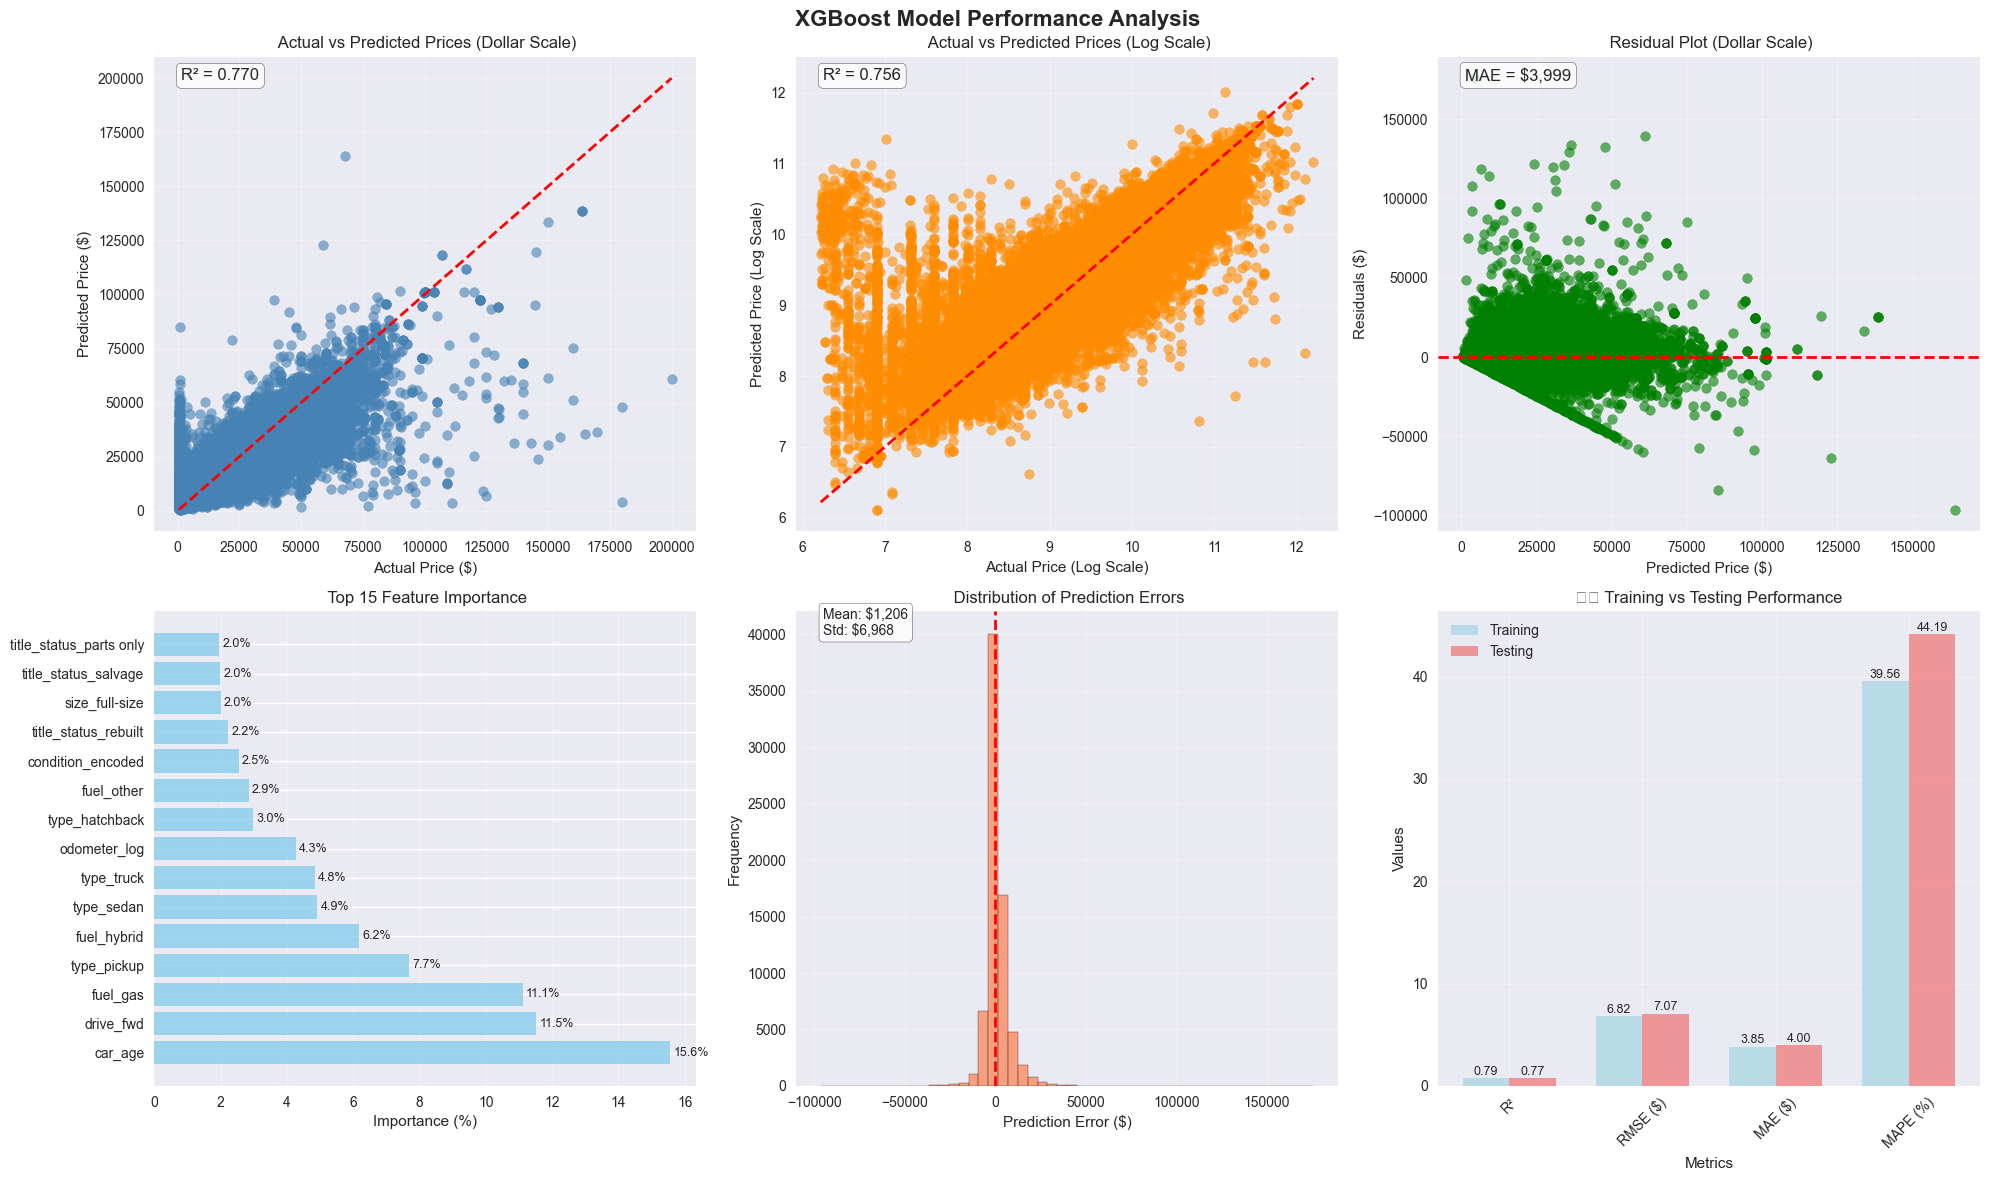


 VISUALIZATION SUMMARY
 Dollar Scale Performance:
   Best predictions within: ±$2,206
   95% of predictions within: ±$13,636
   Largest prediction error: $175,786

 Feature Insights:
   Most important feature: car_age (15.6%)
   Top 3 features contribute: 38.2% of prediction power

 Model Generalization:
    Good generalization - model performs consistently


In [16]:
# Visualization
print("\n" + "=" * 60)
print("STEP 13: VISUALIZATION")
print("=" * 60)

def create_visualizations(evaluation_results):
    """Create comprehensive evaluation visualizations for XGBoost"""
    
    # Extract data from evaluation results
    y_test_actual = evaluation_results['actuals']['test_actual']
    y_test_pred_actual = evaluation_results['predictions']['test_actual']
    y_test_log = evaluation_results['actuals']['test_log']
    y_test_pred_log = evaluation_results['predictions']['test_log']
    feature_importance = evaluation_results['feature_importance']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(' XGBoost Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Actual vs Predicted (Dollar Scale)
    axes[0, 0].scatter(y_test_actual, y_test_pred_actual, alpha=0.6, color='steelblue')
    axes[0, 0].plot([y_test_actual.min(), y_test_actual.max()], 
                    [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Price ($)')
    axes[0, 0].set_ylabel('Predicted Price ($)')
    axes[0, 0].set_title(' Actual vs Predicted Prices (Dollar Scale)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add R² annotation
    r2_actual = evaluation_results['metrics']['test_r2_actual']
    axes[0, 0].text(0.05, 0.95, f'R² = {r2_actual:.3f}', 
                    transform=axes[0, 0].transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 2. Actual vs Predicted (Log Scale)
    axes[0, 1].scatter(y_test_log, y_test_pred_log, alpha=0.6, color='darkorange')
    axes[0, 1].plot([y_test_log.min(), y_test_log.max()], 
                    [y_test_log.min(), y_test_log.max()], 'r--', lw=2)
    axes[0, 1].set_xlabel('Actual Price (Log Scale)')
    axes[0, 1].set_ylabel('Predicted Price (Log Scale)')
    axes[0, 1].set_title(' Actual vs Predicted Prices (Log Scale)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add R² annotation
    r2_log = evaluation_results['metrics']['test_r2_log']
    axes[0, 1].text(0.05, 0.95, f'R² = {r2_log:.3f}', 
                    transform=axes[0, 1].transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 3. Residuals Plot (Dollar Scale)
    residuals_actual = y_test_actual - y_test_pred_actual
    axes[0, 2].scatter(y_test_pred_actual, residuals_actual, alpha=0.6, color='green')
    axes[0, 2].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].set_xlabel('Predicted Price ($)')
    axes[0, 2].set_ylabel('Residuals ($)')
    axes[0, 2].set_title(' Residual Plot (Dollar Scale)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Add MAE annotation
    mae_actual = evaluation_results['metrics']['test_mae_actual']
    axes[0, 2].text(0.05, 0.95, f'MAE = ${mae_actual:,.0f}', 
                    transform=axes[0, 2].transAxes, fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 4. Feature Importance (Top 15)
    if feature_importance is not None:
        top_features = feature_importance.head(15)
        bars = axes[1, 0].barh(range(len(top_features)), top_features['importance_pct'], 
                               color='skyblue', alpha=0.8)
        axes[1, 0].set_yticks(range(len(top_features)))
        axes[1, 0].set_yticklabels(top_features['feature'], fontsize=10)
        axes[1, 0].set_xlabel('Importance (%)')
        axes[1, 0].set_title(' Top 15 Feature Importance')
        axes[1, 0].grid(True, alpha=0.3, axis='x')
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            width = bar.get_width()
            axes[1, 0].text(width + 0.1, bar.get_y() + bar.get_height()/2, 
                           f'{width:.1f}%', ha='left', va='center', fontsize=9)
    else:
        axes[1, 0].text(0.5, 0.5, 'Feature importance\nnot available', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title(' Feature Importance')
    
    # 5. Prediction Error Distribution (Dollar Scale)
    axes[1, 1].hist(residuals_actual, bins=50, alpha=0.7, color='coral', edgecolor='black')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_xlabel('Prediction Error ($)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title(' Distribution of Prediction Errors')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add statistics
    mean_error = np.mean(residuals_actual)
    std_error = np.std(residuals_actual)
    axes[1, 1].text(0.05, 0.95, f'Mean: ${mean_error:,.0f}\nStd: ${std_error:,.0f}', 
                    transform=axes[1, 1].transAxes, fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. Performance Comparison (Train vs Test)
    metrics = ['R²', 'RMSE ($)', 'MAE ($)', 'MAPE (%)']
    train_values = [
        evaluation_results['metrics']['train_r2_actual'],
        evaluation_results['metrics']['train_rmse_actual'] / 1000,  # Convert to thousands
        evaluation_results['metrics']['train_mae_actual'] / 1000,   # Convert to thousands
        evaluation_results['metrics']['train_mape']
    ]
    test_values = [
        evaluation_results['metrics']['test_r2_actual'],
        evaluation_results['metrics']['test_rmse_actual'] / 1000,   # Convert to thousands
        evaluation_results['metrics']['test_mae_actual'] / 1000,    # Convert to thousands
        evaluation_results['metrics']['test_mape']
    ]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    bars1 = axes[1, 2].bar(x - width/2, train_values, width, label='Training', 
                           color='lightblue', alpha=0.8)
    bars2 = axes[1, 2].bar(x + width/2, test_values, width, label='Testing', 
                           color='lightcoral', alpha=0.8)
    
    axes[1, 2].set_xlabel('Metrics')
    axes[1, 2].set_ylabel('Values')
    axes[1, 2].set_title('⚖️ Training vs Testing Performance')
    axes[1, 2].set_xticks(x)
    axes[1, 2].set_xticklabels(metrics, rotation=45)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n VISUALIZATION SUMMARY")
    print("=" * 50)
    print(f" Dollar Scale Performance:")
    print(f"   Best predictions within: ±${np.percentile(np.abs(residuals_actual), 50):,.0f}")
    print(f"   95% of predictions within: ±${np.percentile(np.abs(residuals_actual), 95):,.0f}")
    print(f"   Largest prediction error: ${np.max(np.abs(residuals_actual)):,.0f}")
    
    if feature_importance is not None:
        print(f"\n Feature Insights:")
        top_3 = feature_importance.head(3)
        print(f"   Most important feature: {top_3.iloc[0]['feature']} ({top_3.iloc[0]['importance_pct']:.1f}%)")
        print(f"   Top 3 features contribute: {top_3['importance_pct'].sum():.1f}% of prediction power")
    
    print(f"\n Model Generalization:")
    if evaluation_results['generalization']['overfitting_risk']:
        print(f"     Overfitting detected - consider regularization")
    else:
        print(f"    Good generalization - model performs consistently")

# Run the visualization
create_visualizations(evaluation_results)